# Tutorial 2.2: Deep Learning based IDS

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Under_Construction&color=orange)


**Open notebook on:** 
[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/clandolt/mlcysec_notebooks/blob/main/source/tutorial_notebooks/tutorial2_2_deep_learning_anomaly_detection/tutorial2_2_deep_learning_anomaly_detection.ipynb)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/clandolt/mlcysec_notebooks/blob/main/source/tutorial_notebooks/tutorial2_2_deep_learning_anomaly_detection/tutorial2_2_deep_learning_anomaly_detection.ipynb)   
**Author:** Christoph R. Landolt


In cybersecurity, labeled attack data is often scarce or incomplete. Many attacks are unknown, rare, or stealthy (APT, ATA). Neural network-based unsupervised models, such as Variational Autoencoders (VAE) and One-Class Neural Networks (OC-NN), can learn the normal behavior of network traffic and flag deviations as anomalies. These approaches are particularly useful for intrusion detection, malware monitoring, and unusual user behavior detection.

## Tutorial Objectives
By the end of this tutorial, you will be able to:
- Understand neural network approaches to anomaly detection.
- Explain the mathematical formulation of VAE and OC-NN for anomaly detection.
- Implement VAE and OC-NN using PyTorch.
- Evaluate anomaly detection performance on the KDDCUP99 dataset.

## Neural Network-Based Anomaly Detection in Cybersecurity
Traditional anomaly detection algorithms, such as Isolation Forest or One-Class SVM, can struggle with high-dimensional, complex, or non-linear feature distributions. Neural networks provide:

- **Flexibility:** Can model complex, non-linear relationships.
- **Feature learning:** Automatically extract latent representations.
- **Probabilistic modeling:** In the case of VAE, estimate the likelihood of each observation.

## Variational Autoencoder (VAE)

A **Variational Autoencoder (VAE)** is a *generative probabilistic model* that assumes that each observation $x$ is generated from a latent variable $z$ through a conditional distribution $p_\theta(x \mid z)$.

<img src="./VAE.jpg" alt="VAE" width="600"/>

### Probabilistic Model

We want to maximize the likelihood of the data $x$ by their chosen parameterized probability distribution $p_\theta(x)$ via marginalizing over $z$:
$$
p_\theta(x) = \int_z p_\theta(x , z) \, dz =\int_z p_\theta(x \mid z) \, p_\theta(z) \, dz
$$

where the prior over latent variables is chosen to be the standard normal distribution:
$$
p(z) = \mathcal{N}(0, I)
$$

Since the true posterior $p_\theta(z \mid x)$ is intractable, the VAE introduces an approximate posterior (encoder) $q_\phi(z \mid x)$ to estimate it.

### Training Objective: Evidence Lower Bound (ELBO)

The model is trained by maximizing the **Evidence Lower Bound (ELBO)**:

$$
\mathcal{L}(\theta, \phi; x)
= 
\mathbb{E}_{q_\phi(z \mid x)} [ \log p_\theta(x \mid z) ]
-
D_{\mathrm{KL}}(q_\phi(z \mid x) \, \| \, p(z))
$$

- The **first term** is the *reconstruction likelihood*, encouraging accurate reconstruction of inputs.  
- The **second term** is the *Kullback–Leibler (KL) divergence*, acting as a regularizer to keep the latent space close to the prior $\mathcal{N}(0, I)$.

### Intuition

The VAE consists of two main components:

- **Encoder (Inference network)**: learns to map data $x$ into a latent representation $z$  
  $q_\phi(z \mid x) = \mathcal{N}(\mu(x), \sigma^2(x) I)$
  
- **Decoder (Generative network)**: reconstructs data from the latent representation  
  $p_\theta(x \mid z) = \mathcal{N}(f_\theta(z), \sigma^2 I)$

### Anomaly Detection with VAE

For anomaly detection, the VAE is trained **only on normal samples** to capture the manifold of legitimate data.  
At test time, we compute the **reconstruction error** for each input:

$$
\text{Error}(x) = \| x - \hat{x} \|^2
$$

where $\hat{x} = f_\theta(z)$ is the reconstructed input.

- **Low reconstruction error** → sample lies on the learned manifold → likely normal  
- **High reconstruction error** → sample deviates from normal behavior → potential anomaly

We start by loading the required libraries for this lab:


In [73]:
### Importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

#### Step 1: Load and Explore the KDDCUP99 Dataset


First, we'll load the `SA` subset of the **KDDCUP99 dataset** to keep computation manageable. Then we'll explore and visualize the data.

10065 datapoints with 338 anomalies (3.36%)


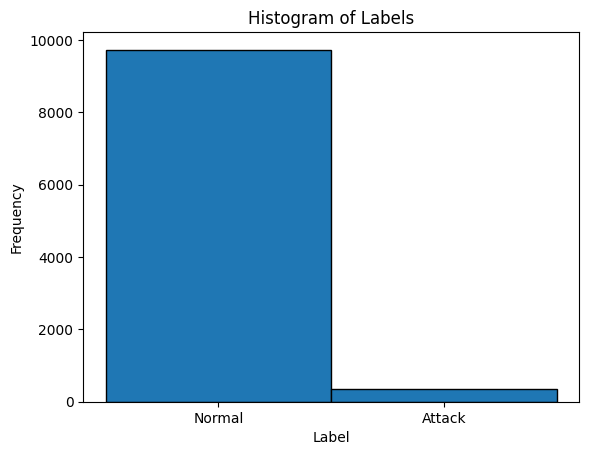

In [74]:

# ### Step 1: Load and Explore the KDDCUP99 Dataset
X, y = datasets.fetch_kddcup99(
    subset="SA",             # Use the 'SA' subset (smaller sample)
    percent10=True,          # Use 10% of the full dataset for efficiency
    random_state=42,         # Ensure reproducibility
    return_X_y=True,         # Return data and labels separately
    as_frame=True            # Load as pandas DataFrame
)

# Convert binary label: 1 = attack, 0 = normal
y = (y != b"normal.").astype(np.int32)

# Take only 10% of the data for quick demonstration
X, _, y, _ = train_test_split(X, y, train_size=0.1, stratify=y, random_state=42)

# Display dataset stats
n_samples, anomaly_frac = X.shape[0], y.mean()
print(f"{n_samples} datapoints with {y.sum()} anomalies ({anomaly_frac:.02%})")

# Plot label distribution
plt.hist(y, bins=[-0.5, 0.5, 1.5], edgecolor='black')
plt.xticks([0, 1], ['Normal', 'Attack'])
plt.title('Histogram of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()


**Notes:**
- The histogram provides a visual overview of **class imbalance** in the dataset. In the KDDCUP99 subset, normal traffic far outnumbers attack events.  
- This imbalance is **typical in cybersecurity datasets**, reflecting real-world conditions where attacks are rare relative to benign activity.  
- From a theoretical perspective, Intrusion Detection Systems (IDS) face two main challenges in such imbalanced environments:
  1. **Scarcity of labeled attack data**: Many attack patterns are unknown, costly to label, or represent vulnerabilities not yet exploited.  
  2. **Diversity of attack types**: Attacks can range from common automated probes to sophisticated Advanced Persistent Threats (APT) and Advanced Targeted Attacks (ATA), which occur rarely and blend into normal traffic.
- Therefore, the observed class imbalance in the histogram **justifies the use of unsupervised anomaly detection models** (such as Isolation Forest) or reconstruction-based models (e.g., Autoencoders), which are trained in a **self-supervised** manner to model the distribution of the 'normal' data.

#### Step 2: Data Preprocessing

Before training, categorical (non-numeric) features must be converted into numerical form.
We’ll use **one-hot encoding** with `pandas.get_dummies()`.


In [75]:
# Convert categorical variables to numerical format
X = pd.get_dummies(X)

print(f"Feature matrix shape after encoding: {X.shape}")
X.head()


Feature matrix shape after encoding: (10065, 6536)


,duration_0,duration_1,duration_2,duration_3,duration_4,duration_5,duration_6,duration_7,duration_8,duration_9,...,dst_host_srv_rerror_rate_0.91,dst_host_srv_rerror_rate_0.92,dst_host_srv_rerror_rate_0.93,dst_host_srv_rerror_rate_0.94,dst_host_srv_rerror_rate_0.95,dst_host_srv_rerror_rate_0.96,dst_host_srv_rerror_rate_0.97,dst_host_srv_rerror_rate_0.98,dst_host_srv_rerror_rate_0.99,dst_host_srv_rerror_rate_1.0
26890,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35471,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
37027,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
80164,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
73649,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


**Notes:**
- Many columns in KDDCUP99 are categorical (e.g., protocol type, service, flag).
- One-hot encoding converts these categories into binary vectors, making them compatible with ML models.


### Step 3: Train-Test Split

We split the dataset into **training (80%)** and **testing (20%)** subsets.


In [76]:
# Split the Dataset into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# Keep only normal samples in the training set
X_train = X_train[y_train == 0]
print(f"Training only on normal points: {len(X_train)} samples")
print("Testing samples:", len(X_test))


Training only on normal points: 7784 samples
Testing samples: 2013


In [77]:
# use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Convert data to PyTorch tensors and put on compute device
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)

#### Step 4: Variational Autoencoder (VAE) Implementation

We define the VAE architecture using three modular `nn.Module` classes: `Encoder`, `Decoder`, and the main `VAE` class which brings them together.

**The Encoder ($q_\phi(z \mid x)$)**<br>
The encoder takes the input data ($x$) and outputs the mean ($\mu$) and log-variance ($\log\sigma^{2}$ or *logvar*) of the **approximate posterior distribution** $q_\phi(z \mid x)$.


In [78]:
# Define input and latent dimensions
input_dim = X_train.shape[1]
latent_dim = 10

# --- 1. Encoder Class ---
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        
        # Feature extraction part (equivalent to fc1 + ReLU in original)
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.Tanh()
        )
        
        # Layers for mean (mu) and log variance (logvar)
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

    def forward(self, x):
        # Latent space parameters
        h = self.feature_extractor(x)
        # Compute mean (mu) and log variance (logvar)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar



**The Decoder ($p_\theta(x \mid z)$)**<br>
The decoder takes a sample from the latent space ($z$) and attempts to reconstruct the original input data ($x$).

In [79]:
# --- 2. Decoder Class ---
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        
        # Decoder network (equivalent to fc2 + ReLU + fc3 in original)
        self.decoder_net = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.Tanh(),
            nn.Linear(64, output_dim)
        )

    def forward(self, z):
        return self.decoder_net(z)


**The Main VAE Model**<br>
The main VAE class combines the Encoder and Decoder and implements the **Reparameterization Trick**, which is crucial for enabling backpropagation through the sampling process.

In [80]:
# --- 3. Adapted VAE Class (Main Model) ---
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super().__init__()
        
        # Instantiate the explicit Encoder and Decoder modules
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)
    
    def reparameterize(self, mu, logvar):
        """
        Samples z from the latent distribution (N(mu, exp(logvar))) 
        using the reparameterization trick.
        """
        std = torch.exp(0.5 * logvar)
        # eps is a random vector from the standard normal distribution
        eps = torch.randn_like(std) 
        return mu + eps * std
    
    def forward(self, x):
        # 1. Encode: Get the parameters of the latent distribution
        mu, logvar = self.encoder(x)
        
        # 2. Reparameterize: Sample a latent vector z
        z = self.reparameterize(mu, logvar)
        
        # 3. Decode: Reconstruct the input
        recon = self.decoder(z)
        
        return recon, mu, logvar

**The VAE Loss Function (ELBO)**<br>
The VAE minimizes the negative of the **Evidence Lower Bound (ELBO)**, which consists of two terms:

1.  **Reconstruction Loss:** Measures how well the output is reconstructed (e.g., Mean Squared Error or MSE).
2.  **KL Divergence Loss:** A regularization term that measures the difference between the approximate posterior $q_\phi(z \mid x)$ and the prior $p(z) = \mathcal{N}(\mathbf{0}, \mathbf{I})$.

In [81]:
# --- 4. Loss Function ---
def vae_loss(recon_x, x, mu, logvar):
    """
    Computes the VAE loss, which is the sum of:
    1. Reconstruction Loss (e.g., MSE or BCE)
    2. KL Divergence Loss
    """
    # Reconstruction Loss (using MSE as per original code)
    recon_loss = nn.MSELoss(reduction='sum')(recon_x, x) # Using 'sum' instead of 'mean' for better KLD scaling, then we'll divide by batch size/N below
    
    # KL Divergence Loss: KLD = -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss (divided by batch size for consistency)
    total_loss = (recon_loss + kld) / x.size(0) # x.size(0) is the batch size
    return total_loss

**Instantiation and Architecture**


In [82]:
# --- 5. Model Instantiation and Optimizer ---
vae = VAE(input_dim, latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# print neural network architecture
print(vae)

VAE(
  (encoder): Encoder(
    (feature_extractor): Sequential(
      (0): Linear(in_features=6536, out_features=64, bias=True)
      (1): Tanh()
    )
    (fc_mu): Linear(in_features=64, out_features=10, bias=True)
    (fc_logvar): Linear(in_features=64, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (decoder_net): Sequential(
      (0): Linear(in_features=10, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=6536, bias=True)
    )
  )
)


#### Step 5: Training Loop
The training loop is where the model learns from the data over multiple epochs. An epoch refers to one full pass through the entire training dataset.

Epoch 01/50, Train Loss: 578.6677, Test Loss: 0.0819
Epoch 05/50, Train Loss: 412.0530, Test Loss: 0.0573
Epoch 10/50, Train Loss: 260.2814, Test Loss: 0.0362
Epoch 15/50, Train Loss: 161.6439, Test Loss: 0.0225
Epoch 20/50, Train Loss: 102.5268, Test Loss: 0.0140
Epoch 25/50, Train Loss: 67.5168, Test Loss: 0.0090
Epoch 30/50, Train Loss: 48.5958, Test Loss: 0.0062
Epoch 35/50, Train Loss: 37.9609, Test Loss: 0.0046
Epoch 40/50, Train Loss: 31.5783, Test Loss: 0.0035
Epoch 45/50, Train Loss: 27.7018, Test Loss: 0.0029
Epoch 50/50, Train Loss: 25.9101, Test Loss: 0.0026


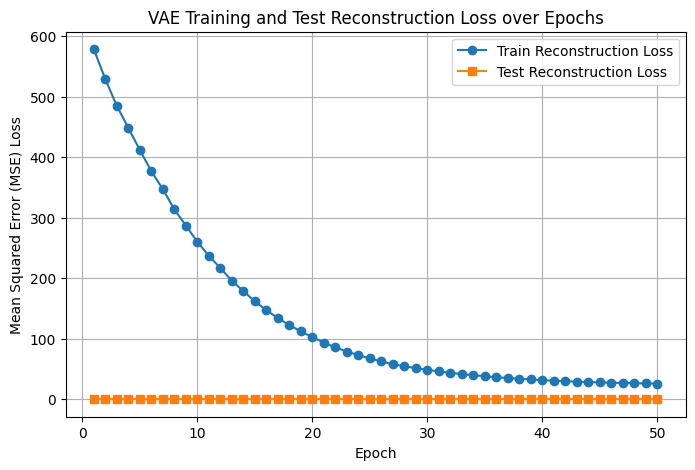

In [83]:
num_epochs = 50
# --- Track losses ---
train_losses = []
test_losses = []


# --- 6. Training Loop ---
for epoch in range(1, num_epochs + 1):
    vae.train()
    optimizer.zero_grad()

    # Forward pass
    recon_x, mu, logvar = vae(X_train_tensor)
    loss = vae_loss(recon_x, X_train_tensor, mu, logvar)
    loss.backward()
    optimizer.step()

    # Evaluate on test data (reconstruction only)
    vae.eval()
    with torch.no_grad():
        recon_test, mu_t, logvar_t = vae(X_test_tensor)
        test_loss = nn.MSELoss()(recon_test, X_test_tensor)

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d}/{num_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

# --- Plot train and test reconstruction loss ---
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Reconstruction Loss', marker='o')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Reconstruction Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE) Loss')
plt.title('VAE Training and Test Reconstruction Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


#### Step 6: Compute Reconstruction-Based Anomaly Scores

For anomaly detection, the core principle of a reconstruction-based model (like the VAE) is:

> **High reconstruction error** → **likely anomaly** (The model struggles to reconstruct data it hasn't seen frequently).

We calculate the Mean Squared Error (MSE) between the original test data and its VAE reconstruction to serve as the anomaly score.

In [84]:
# --- Compute Reconstruction Error on Test Set ---
vae.eval()
with torch.no_grad():
    # Only need the reconstruction (recon_test) from the forward pass
    recon_test, _, _ = vae(X_test_tensor) 
# Calculate MSE for each sample: mean((original - reconstructed)^2)
errors = torch.mean((X_test_tensor - recon_test)**2, dim=1).cpu().numpy()

**Setting the Anomaly Threshold**<br>
A threshold is needed to classify a sample as 'Normal' or 'Attack'. A common heuristic in unsupervised anomaly detection is to set the threshold based on the distribution of reconstruction errors observed on the **training data** (which is assumed to be mostly 'Normal'). Here, we use the **95th percentile** of the training errors.

In [85]:
# --- Choose Threshold: 95th percentile of reconstruction error on training set ---
with torch.no_grad():
    recon_train, _, _ = vae(X_train_tensor)
train_errors = torch.mean((X_train_tensor - recon_train)**2, dim=1).cpu().numpy()
# Use NumPy's percentile function
threshold = np.percentile(train_errors, 95) 

# --- Predict anomalies ---
# Predict 1 (Anomaly/Attack) if error > threshold, 0 (Normal) otherwise
y_pred = (errors > threshold).astype(int)

#### Step 7: Evaluation and Results
We use the confusion matrix and classification report to evaluate the performance of our VAE-based detector on the labeled test set.

Confusion Matrix:
 [[1844   99]
 [  51   19]]

Classification Report:
               precision    recall  f1-score   support

      Normal       0.97      0.95      0.96      1943
      Attack       0.16      0.27      0.20        70

    accuracy                           0.93      2013
   macro avg       0.57      0.61      0.58      2013
weighted avg       0.94      0.93      0.93      2013



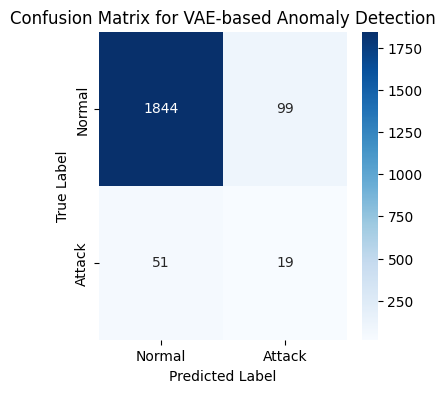

In [86]:
# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Normal', 'Attack']))

# --- Plot Confusion Matrix ---
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for VAE-based Anomaly Detection')
plt.show()

## Exercises
### Exercise 1: Nonstationarity in Cybersecurity Data

A stochastic process $\{X_t\}$ is defined as **nonstationary** if its joint probability distribution, or any of its statistical properties (such as the mean, variance, and autocorrelation), changes over time $t$.

In the context of Machine Learning, this phenomenon is often referred to as **data drift** or **concept drift**, and it poses a fundamental challenge in ML for cybersecurity.

**Theory Question:**

1) Explain why the nonstationary nature of network traffic and threat landscapes is a core challenge for trained Machine Learning models (like the VAE) used for Intrusion Detection Systems (IDS). Specifically, how does it relate to the VAE's objective of learning the "normal manifold" $P(X)$?

2) classify each of the following common cybersecurity effects by the primary type of nonstationarity they induce on the training data distribution ($P(X)$) or the relationship between features and labels ($P(Y \mid X)$).

**Classification Options:**

*   **Covariate Shift:** The input distribution $P(X)$ changes, but the attack/normal relationship $P(Y \mid X)$ remains the same.
*   **Abrupt Concept Drift:** The attack/normal relationship $P(Y \mid X)$ changes suddenly (e.g., a new attack type is introduced).
*   **Gradual Concept Drift:** The attack/normal relationship $P(Y \mid X)$ changes slowly over time.


In [ ]:
# | Cybersecurity Effect                            | Primary Type of Nonstationarity |
# | :-------------------                            | :------------------------------ |
# | **Zero-Day Exploits**                           |                                 |
# | **Patching & Security Configuration Changes**   |                                 |
# | **Deployment of New Services/Infrastructure**   |                                 |
# | **Changing User/IT Behavior**                   |                                 |

### Exercise 2: Practical Hyperparameter Tuning and Impact
Modify the implemented VAE code to analyze the impact of two critical hyperparameters:

1.  **Latent Dimension (`latent_dim`):** Change `latent_dim` from `10` to `2`. Why might a smaller latent space (2 vs 10) be better or worse for this particular anomaly detection task? Can you find an optimal value for the `latent_dim`?
2.  **KL Divergence Weight:** Introduce a hyperparameter $\beta$ to the `vae_loss` function such that the new loss is $\mathcal{L}_{VAE} = \text{Reconstruction Loss} + \beta \cdot \text{KL Divergence Loss}$. Set $\beta = 0.1$ (a weaker regularization). Explain the trade-off you observe between the reconstruction loss, the KL divergence loss (regularization), and the final anomaly detection performance (Precision/Recall for 'Attack' class). Can you find an optimal value for the $\beta$?

## Conclusion

In this tutorial we used a Variational Autoencoder (VAE) as a **self-supervised** anomaly detection technique for cybersecurity data. We successfully implemented the VAE in PyTorch, focusing on training the model exclusively on 'Normal' data to learn its specific manifold. By using the reconstruction error as the anomaly score and applying a threshold, we were able to flag deviations as potential attacks, highlighting the VAE's utility in addressing the challenge of unlabeled data for certain security events and zero-day threat detection in IDS.


---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/clandolt/mlcysec_notebooks/)  If you found this tutorial helpful, please **⭐ star our repository** to show your support.   
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/clandolt/mlcysec_notebooks/issues)  For any **questions**, **typos**, or **bugs**, kindly open an issue on GitHub — we appreciate your feedback!

---